## Load and Preprocess

In [30]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from   timeit import default_timer as timer

In [31]:
train_full = pd.read_csv("./MNIST Dataset/sign_mnist_train.csv")
test       = pd.read_csv("./MNIST Dataset/sign_mnist_test.csv")

In [32]:
label_map = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
np.save("./labels.npy", label_map)

In [33]:
X_train_full = train_full.values[:,1:].astype(np.float32())
y_train_full = train_full.values[:,0]
X_test = test.values[:,1:].astype(np.float32())
y_test = test.values[:,0]

In [34]:
# splitting validation set from the training set using stratified splitting
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 2500)
for train_index, test_index in split.split(X_train_full, y_train_full):
    X_train, X_val = X_train_full[train_index], X_train_full[test_index]
    y_train, y_val = y_train_full[train_index], y_train_full[test_index]

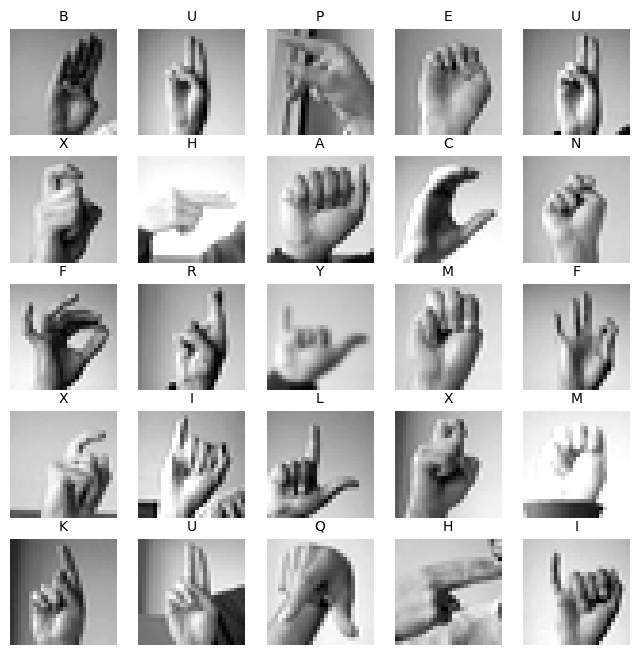

In [35]:
# visualizing random images from the training set
fig, axs = plt.subplots(nrows = 5, ncols = 5, figsize = (8, 8))
train_len = X_train.shape[0]

for ax in axs.reshape(-1):
    idx = np.random.randint(train_len)
    ax.set_title(label_map[y_train[idx]], size = 10)
    ax.axis("off")
    ax.imshow(X_train[idx].reshape((28, 28)), cmap = "gray")

In [36]:
from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

## CNN

In [37]:
# function to plot the learning curves
def plot_results(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 7))

    ax1.plot(history["loss"], label = "Train loss")
    ax1.plot(history["val_loss"], label = "Validation loss")
    ax2.plot(history["accuracy"], label = "Train accuracy")
    ax2.plot(history["val_accuracy"], label = "Validation accuracy")

    ax1.legend(fontsize = 15)
    ax2.legend(fontsize = 15)

    ax1.set_title("Loss vs. epoch", fontsize = 25)
    ax1.set_xlabel("epoch", fontsize = 20)
    ax2.set_title("Accuracy vs. epoch", fontsize = 25)
    ax2.set_xlabel("epoch", fontsize = 20)

    ax1.grid(True)
    ax2.grid(True)

In [38]:
X_train     = np.array([X_train]).reshape((X_train.shape[0], 28, 28, 1))
X_val       = np.array([X_val])  .reshape((X_val.shape[0], 28, 28, 1))
X_test      = np.array([X_test]) .reshape((X_test.shape[0], 28, 28, 1))
image_shape = X_train[0].shape
print(image_shape)

(28, 28, 1)


In [41]:
# Creates a 3DCNN
cnn3d = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (30, 28, 28, 1)),
    tf.keras.layers.Reshape((30, 28, 28), input_shape = (30, 28, 28, 1)),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.15, 0.15),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.15),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.Reshape((30, 28, 28, 1), input_shape = (30, 28, 28)),
    tf.keras.layers.Conv3D(8, kernel_size = (3, 3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv3D(8, kernel_size = (3, 3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool3D(pool_size = 2, strides = 2, padding = "valid"),
    tf.keras.layers.Conv3D(16, kernel_size = (3, 3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv3D(16, kernel_size = (3, 3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool3D(pool_size = 2, strides = 2, padding = "valid"),
    tf.keras.layers.Conv3D(32, kernel_size = (3, 3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv3D(32, kernel_size = (3, 3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool3D(pool_size = 2, strides = 2, padding = "valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(len(label_map), activation = "softmax")
])
cnn3d.summary()

ValueError: Input 0 of layer "conv3d_13" is incompatible with the layer: expected min_ndim=5, found ndim=4. Full shape received: (None, 30, 28, 28)

In [ ]:
tf.keras.utils.plot_model(cnn3d, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Train the CNN

In [ ]:
# Defines the sequences to feed into the 3DCNN
temp_sequence   = [0] * 30
train_sequences = [0] * X_train.shape[0]
test_sequences  = [0] * X_test.shape[0]
val_sequences   = [0] * X_val.shape[0]

# Creates the training sequences
for i in range(0, X_train.shape[0]):
    for j in range(0, 30):
        temp_sequence[j] = X_train[i]
    train_sequences[i] = temp_sequence

# Creates the test sequences
for i in range(0, X_test.shape[0]):
    for j in range(0, 30):
        temp_sequence[j] = X_test[i]
    test_sequences[i] = temp_sequence

# Creates the val sequences
for i in range(0, X_val.shape[0]):
    for j in range(0, 30):
        temp_sequence[j] = X_val[i]
    val_sequences[i] = temp_sequence

train_sequences = np.array(train_sequences)
test_sequences  = np.array(test_sequences)
val_sequences   = np.array(val_sequences)

(24955, 30, 28, 28, 1)


In [ ]:
# Defines the optimizer
customOptimizer = tf.keras.optimizers.Adam(5e-4)

# Defines the loss function
customLoss      = tf.keras.losses.SparseCategoricalCrossentropy()

# Defines the callbacks to include
my_callbacks = [
    #tf.keras.callbacks.ModelCheckpoint(filepath = "./MNIST Models 3D/Accuracy/mnist_detection.acc.{epoch:02d}-{val_accuracy:.2f}.h5", monitor = "val_accuracy", mode = "max", save_best_only = True),
    #tf.keras.callbacks.ModelCheckpoint(filepath = "./MNIST Models 3D/Loss/mnist_detection.loss.{epoch:02d}-{val_loss:.2f}.h5", monitor = "val_loss", mode = "min", save_best_only = True),
    tf.keras.callbacks.EarlyStopping  (patience = 200, monitor = "accuracy"),
    #tf.keras.callbacks.TensorBoard    (log_dir  = "./Logs")
]

# Compile the model
cnn3d.compile(optimizer = customOptimizer, loss = customLoss, metrics = ["accuracy"], jit_compile = None)

In [ ]:
start_train = timer()
history     = cnn3d.fit(train_sequences, y_train, epochs = 20, batch_size = 16, validation_data = (val_sequences, y_val), callbacks = my_callbacks, use_multiprocessing = True)
end_train   = timer()

390/390 [==============================] - 1209s 3s/step - loss: 3.2090 - accuracy: 0.0466 - val_loss: 3.2064 - val_accuracy: 0.0464


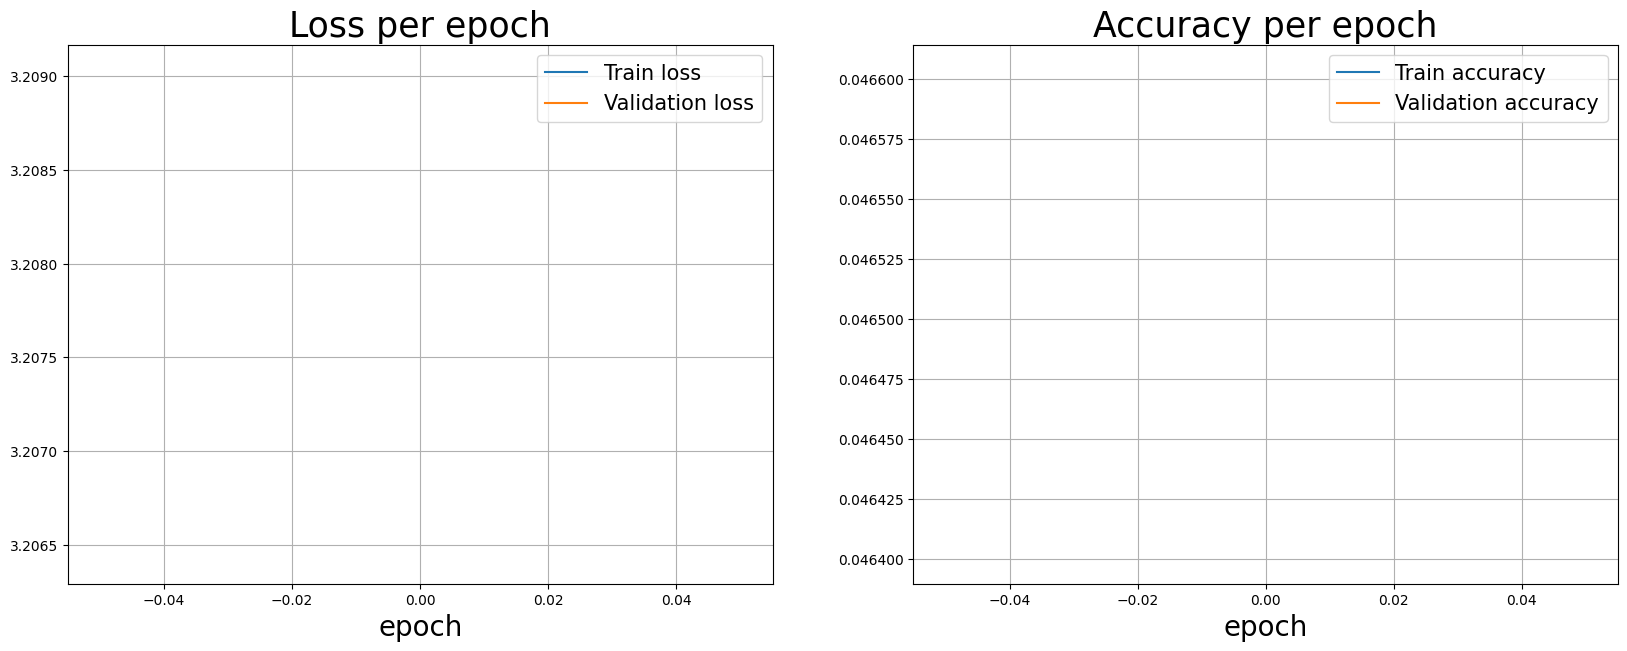

In [ ]:
# Plot learning Curves
plot_results(history.history)

## 3DCNN Evaluation

In [ ]:
# 3DCNN evaluation
start_pred = timer()
train_acc  = cnn3d.evaluate(train_sequences, y_train)[1]
end_pred   = timer()
test_acc   = cnn3d.evaluate(test_sequences, y_test)[1]
model_data = [end_train - start_train, end_pred - start_pred, train_acc, test_acc]

225/225 [==============================] - 30s 132ms/step - loss: 3.2218 - accuracy: 0.0229


In [ ]:
test_pred = np.argmax(cnn3d.predict(test_sequences), axis = 1)

225/225 [==============================] - 30s 132ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: ", precision_score(y_test, test_pred, average = "micro").round(2))
print("Recall: "   , recall_score   (y_test, test_pred, average = "micro").round(2))
print("F1 Score: " , f1_score       (y_test, test_pred, average = "micro").round(2))

Precision:  0.02
Recall:  0.02
F1 Score:  0.02


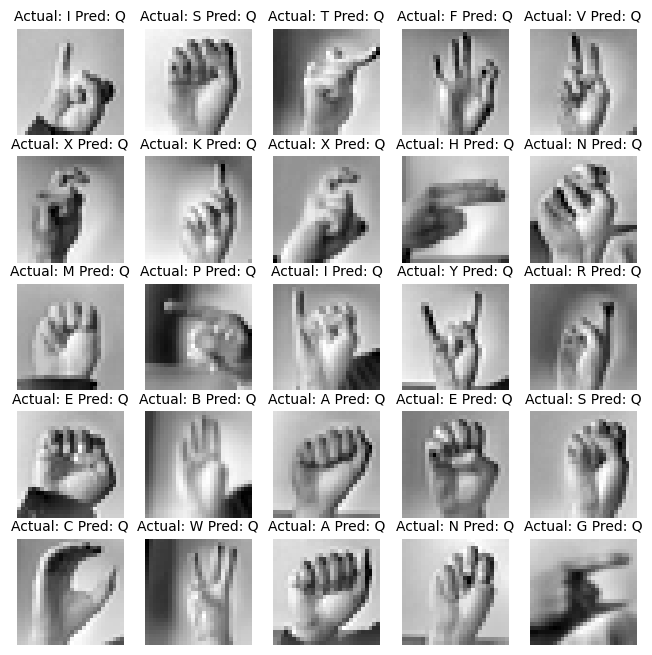

In [ ]:
# visualizing predictions of random images from the test set
fig, axs = plt.subplots(nrows = 5, ncols = 5, figsize = (8, 8))
test_len = X_test.shape[0]

for ax in axs.reshape(-1):
    idx = np.random.randint(test_len)
    pred = test_pred[idx]
    ax.set_title("Actual: " + label_map[y_test[idx]] + " Pred: " + label_map[pred], size = 10)
    ax.axis("off")
    ax.imshow(X_test[idx], cmap="gray")

## Model Evaluation

In [ ]:
# Store values
trainTime = round(model_data[0], 2)
testTime  = round(model_data[1], 2)
trainAcc  = round(model_data[2], 2)
testAcc   = round(model_data[3], 2)

In [ ]:
# Print info about the model
print("Training Time: {} Hours, {} Minutes, {} Seconds".format(int(round(trainTime / 3600, 0)), int(round((trainTime % 3600) / 60, 0)), int(round(((trainTime % 3600) % 60) / 60, 0))))
print("Prediction Time:", testTime, "seconds")
print("Training Accuracy: " + str(trainAcc * 100) + "%")
print("Prediction Accuracy: " + str(testAcc * 100) + "%")

Training Time: 0 Hours, 20 Minutes, 0 Seconds
Prediction Time: 104.42 seconds
Training Accuracy: 5.0%
Prediction Accuracy: 2.0%
